In [2]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [3]:
# Загрузка данных
train_df = pd.read_csv('/Users/ivan/Desktop/Тестовое контакт 2/train_spam.csv')
test_df = pd.read_csv('/Users/ivan/Desktop/Тестовое контакт 2/test_spam.csv')

In [4]:
train_df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [5]:
test_df

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [6]:
# Проверяю на наличие пропусков в данных
print(f'Пропусков в обучающей выборке: {train_df.isna().sum().sum()}')
print(f'Пропусков в тестовой выборке: {test_df.isna().sum().sum()}')

Пропусков в обучающей выборке: 0
Пропусков в тестовой выборке: 0


Распределение классов:
ham     11469
spam     4809
Name: text_type, dtype: int64


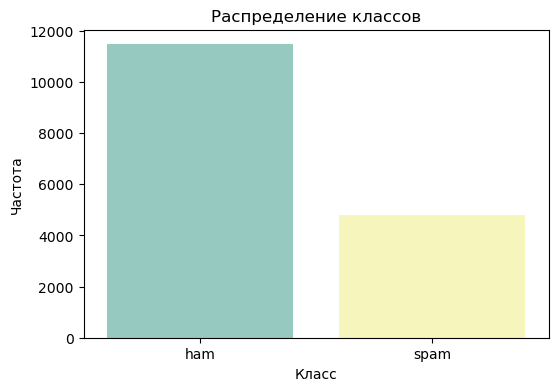

In [7]:
# Проверяю распределение классов
print("Распределение классов:")
print(train_df['text_type'].value_counts())

# Построение распределения классов
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='text_type', palette='Set3')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.show()

In [8]:
# Заменяю колонку text_type: 0 не спам, 1 - спам
train_df['text_type'] = train_df['text_type'].map({'ham': 0, 'spam': 1})

In [9]:
# Разделяю выборку на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['text_type'], test_size=0.2, random_state=42)

In [10]:
# Создание TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Преобразование текста в числовой формат
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

<span style="color:dimgray; font-size:20px">1. Логистическая регрессия</span>


In [11]:
# Инициализация и обучение логистической регрессии

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)

# Прогнозирование на тренировочной выборке
y_train_pred_proba = logistic_regression.predict_proba(X_train_tfidf)[:, 1]

# Вычисление ROC-AUC на тренировочной выборке
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
print("ROC-AUC на тренировочной выборке:", roc_auc_train)


# Прогнозирование на валидационной выборке
y_val_pred_proba = logistic_regression.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC на валидационной выборке
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print("ROC-AUC на валидационной выборке:", roc_auc)

ROC-AUC на тренировочной выборке: 0.9908258057314366
ROC-AUC на валидационной выборке: 0.9810875821089471


In [12]:
# Пробую улучшить модель с помощью перебора гиперпараметров
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Параметр регуляризации
    'penalty': ['l2']  # Тип регуляризации
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')

# Подгонка GridSearchCV к данным
grid_search.fit(X_train_tfidf, y_train)

# Получение наилучших гиперпараметров
best_params = grid_search.best_params_
print("Наилучшие гиперпараметры:", best_params)

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Прогнозирование на валидационной выборке с использованием лучшей модели
y_val_pred_proba = best_model.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print("ROC-AUC на валидационной выборке после настройки гиперпараметров:", roc_auc)

Наилучшие гиперпараметры: {'C': 10, 'penalty': 'l2'}
ROC-AUC на валидационной выборке после настройки гиперпараметров: 0.9835726809622443


<span style="color:dimgray; font-size:20px">2. Случайный лес</span>

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели случайного леса
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_tfidf, y_train)

# Прогнозирование на валидационной выборке
y_val_pred_proba_rf = random_forest.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC для модели случайного леса
roc_auc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)
print("ROC-AUC для модели случайного леса на валидационной выборке:", roc_auc_rf)

ROC-AUC для модели случайного леса на валидационной выборке: 0.9846124780255606


In [16]:
# Пробую улучшить модель с помощью перебора гиперпараметров

# Определение сетки гиперпараметров для случайного леса
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [False],
    'clf__class_weight': ['balanced']
}
# Инициализация модели случайного леса
random_forest_model = RandomForestClassifier(random_state=42)

# Создание пайплайна
pipeline_rf = Pipeline([('vect', TfidfVectorizer()), ('clf', random_forest_model)])

# Поиск лучших параметров с помощью кросс-валидации
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'clf__bootstrap': False, 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}


In [17]:
best_model_rf = grid_search_rf.best_estimator_

# Прогнозирование на валидационной выборке с использованием лучшей модели случайного леса
y_val_pred_proba_rf = best_model_rf.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC для случайного леса
roc_auc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)
print("ROC-AUC для модели случайного леса на валидационной выборке после настройки гиперпараметров:", roc_auc_rf)

ROC-AUC для модели случайного леса на валидационной выборке после настройки гиперпараметров: 0.9915330152271632


<span style="color:dimgray; font-size:20px">3. Наивный Байесовский классификатор</span>



In [18]:
from sklearn.naive_bayes import MultinomialNB

# Инициализация и обучение модели
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)

# Прогнозирование на валидационной выборке
y_val_pred_proba_nb = naive_bayes.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC для модели наивного Байеса
roc_auc_nb = roc_auc_score(y_val, y_val_pred_proba_nb)
print("ROC-AUC для модели наивного Байеса на валидационной выборке:", roc_auc_nb)

ROC-AUC для модели наивного Байеса на валидационной выборке: 0.9735041829194958


<span style="color:dimgray; font-size:20px">4. XGBoost</span>


In [21]:
import xgboost as xgb

# Инициализация модели XGBoost
xgb_model = xgb.XGBClassifier()
# Обучение модели
xgb_model.fit(X_train_tfidf, y_train)

y_train_pred_proba_xgb = xgb_model.predict_proba(X_train_tfidf)[:, 1]

# Вычисление ROC-AUC для модели XGBoost на тренировочной выборке
roc_auc_xgb_train = roc_auc_score(y_train, y_train_pred_proba_xgb)
print("ROC-AUC для модели XGBoost на тренировочной выборке:", roc_auc_xgb_train)

# Прогнозирование на валидационной выборке
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC для модели XGBoost
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
print("ROC-AUC для модели XGBoost на валидационной выборке:", roc_auc_xgb)

ROC-AUC для модели XGBoost на тренировочной выборке: 0.9936295110587802
ROC-AUC для модели XGBoost на валидационной выборке: 0.976280738295083


In [27]:
# пробую подобрать гиперпараметры
param_grid = {
    'max_depth': [3, 5, 7],  # Максимальная глубина деревьев
    'learning_rate': [0.1, 0.01, 0.001],  # Скорость обучения
    'n_estimators': [100, 200, 300],  # Количество деревьев в ансамбле
    'gamma': [0, 0.1, 0.2],  # Минимальное уменьшение потерь для деления
}

xgb_model = xgb.XGBClassifier()
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search_xgb.fit(X_train_tfidf, y_train)

# Получение наилучших гиперпараметров
best_params_xgb = grid_search_xgb.best_params_
print("Наилучшие гиперпараметры для модели XGBoost:", best_params_xgb)


Наилучшие гиперпараметры для модели XGBoost: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [28]:
# Получение лучшей модели
best_model_xgb = grid_search_xgb.best_estimator_

# Прогнозирование на тренировочной выборке с использованием лучшей модели
y_train_pred_proba_xgb = best_model_xgb.predict_proba(X_train_tfidf)[:, 1]

# Вычисление ROC-AUC на тренировочной выборке
roc_auc_xgb_train = roc_auc_score(y_train, y_train_pred_proba_xgb)
print("ROC-AUC для модели XGBoost на тестовой выборке после настройки гиперпараметров:", roc_auc_xgb_test)

# Прогнозирование на валидационной выборке с использованием лучшей модели
y_val_pred_proba_xgb = best_model_xgb.predict_proba(X_val_tfidf)[:, 1]

# Вычисление ROC-AUC
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
print("ROC-AUC для модели XGBoost на валидационной выборке после настройки гиперпараметров:", roc_auc_xgb)

ROC-AUC для модели XGBoost на тестовой выборке после настройки гиперпараметров: 0.9936295110587802
ROC-AUC для модели XGBoost на валидационной выборке после настройки гиперпараметров: 0.9797381268907234


<span style="color:dimgray; font-size:20px">
Вывод:

Лучше всего себя показала модель случайного леса</span>


In [29]:
# Предсказываю вероятности принадлежности к 1 классу в тестовой выборке
y_test_pred_proba_rf = best_model_rf.predict_proba(test_df['text'])[:, 1]
results_df = pd.DataFrame({'text_type': y_test_pred_proba_rf, 'text': test_df['text']})
results_df

,text_type,text
0,0.118281,j jim whitehead ejw cse ucsc edu writes j you ...
1,0.263561,original message from bitbitch magnesium net p...
2,0.103157,java for managers vince durasoft who just taug...
3,0.041963,there is a youtuber name saiman says
4,0.713531,underpriced issue with high return on equity t...
...,...,...
4065,0.205433,husband to wifetum meri zindagi hoorwifeor kya...
4066,0.048513,baylor enron case study cindy yes i shall co a...
4067,0.185413,boring as compared to tp
4068,0.148913,hellogorgeous hows u my fone was on charge lst...


In [36]:
# Пороговое значение
threshold = 0.5

# Преобразую вероятности в бинарные предсказания
binary_predictions = (y_test_pred_proba_rf > threshold).astype(int)

# Создаю Final DataFrame
results_df_final = pd.DataFrame({'score': binary_predictions, 'text': test_df['text']})
results_df_final

,score,text
0,0,j jim whitehead ejw cse ucsc edu writes j you ...
1,0,original message from bitbitch magnesium net p...
2,0,java for managers vince durasoft who just taug...
3,0,there is a youtuber name saiman says
4,1,underpriced issue with high return on equity t...
...,...,...
4065,0,husband to wifetum meri zindagi hoorwifeor kya...
4066,0,baylor enron case study cindy yes i shall co a...
4067,0,boring as compared to tp
4068,0,hellogorgeous hows u my fone was on charge lst...


In [38]:
results_df_final['score'] = results_df_final['score'].replace({0: 'ham', 1: 'spam'})
results_df_final

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,spam,underpriced issue with high return on equity t...
...,...,...
4065,ham,husband to wifetum meri zindagi hoorwifeor kya...
4066,ham,baylor enron case study cindy yes i shall co a...
4067,ham,boring as compared to tp
4068,ham,hellogorgeous hows u my fone was on charge lst...


In [41]:
results_df_final.to_csv('results.csv', index=False)